In [1]:
import lbg_forecast.priors_gp_massfunc as gpmf
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import lbg_forecast.utils as utils

mass_function_prior = gpmf.MassFunctionPrior('.', mean=False)


In [2]:
run='test_0'

#spsp = np.load("sps_parameter_samples/sps_"+run+"_"+str(id)+".npy")
#photometry = np.load("photo_samples/photo_"+run+"_"+str(id)+".npy")
#ntot = np.load("sps_parameter_samples/nlsst_"+run+"_"+str(id)+".npy")*utils.FULL_SKY_DEG2

spsp = np.load("sps_parameter_samples/sps_"+run+".npy")
photometry = np.load("photo_samples/photo_"+run+".npy")
ntot = np.load("sps_parameter_samples/nlsst_"+run+".npy")


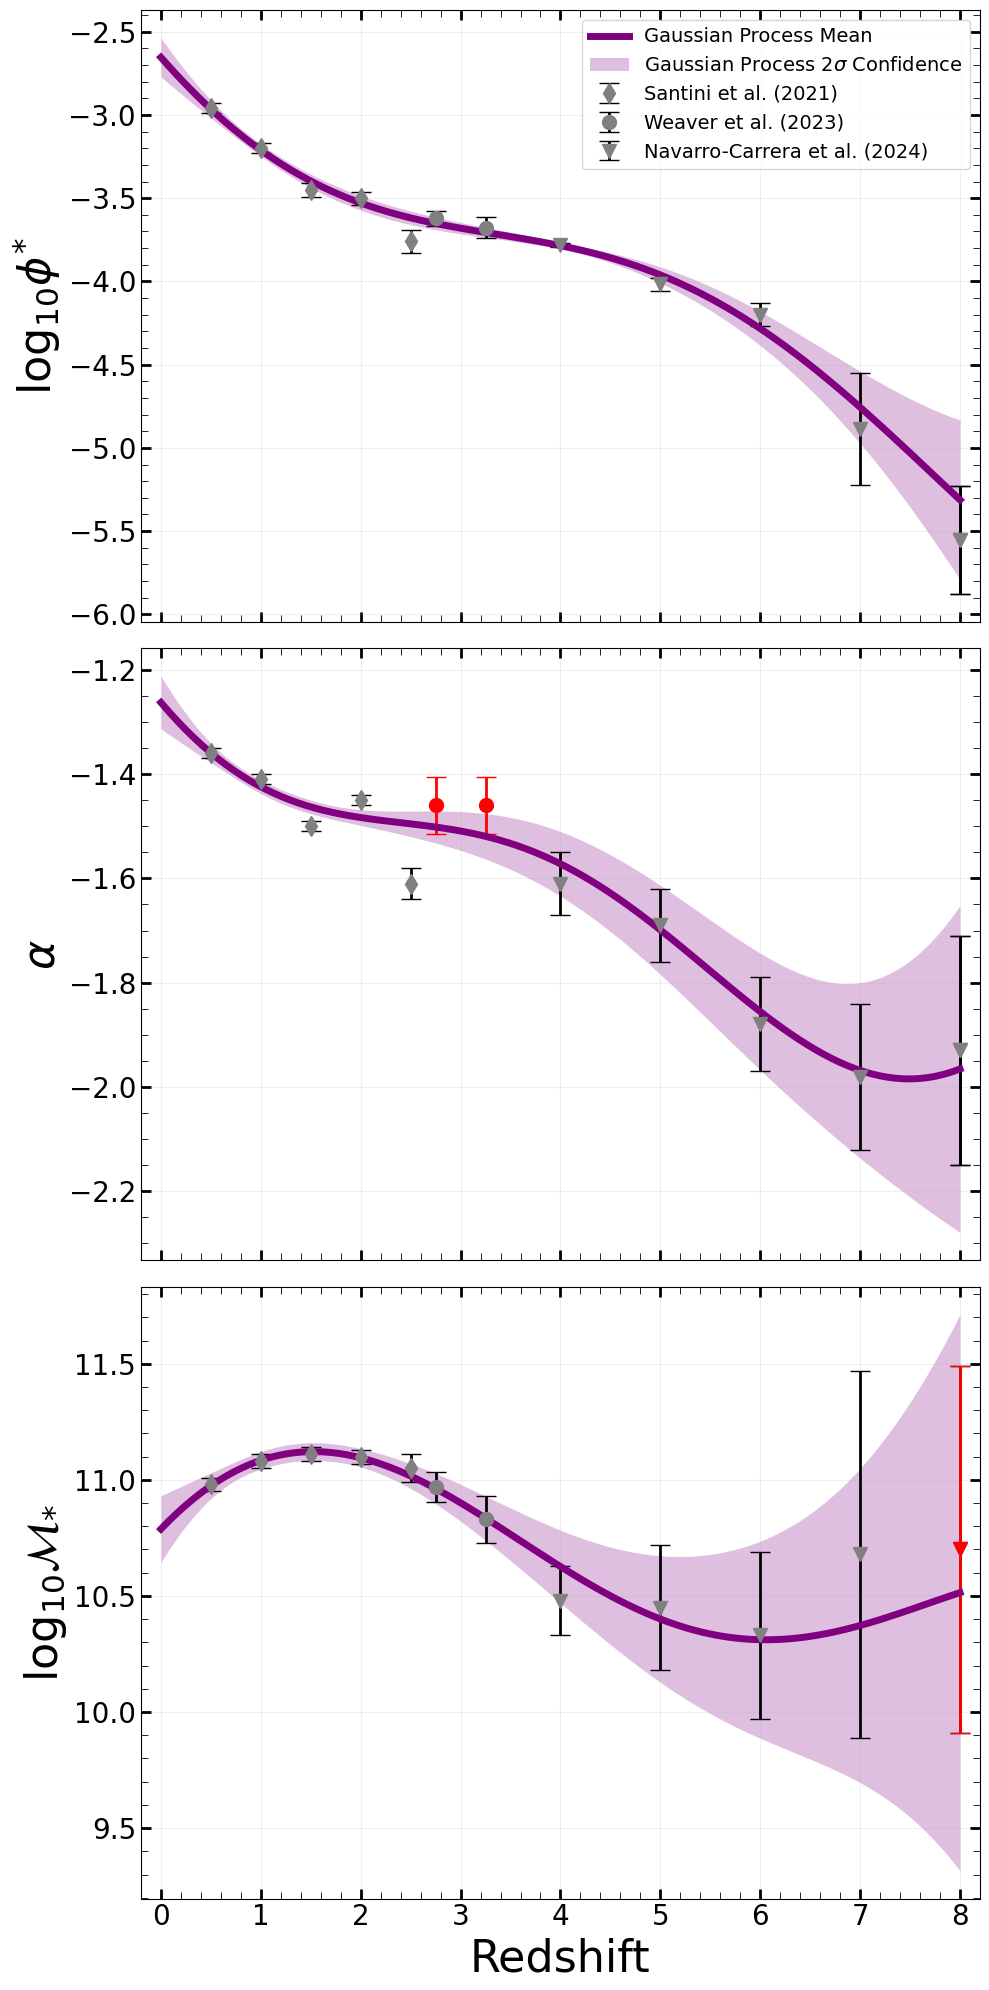

In [2]:
mass_function_prior.plot_confidence()

In [6]:
print("LSST Number Density: ", mass_function_prior.lsst_number_density(mass_function_prior.sample_prior_mean()))


LSST Number Density:  2582112.4233077243


In [7]:
N_tot=[]
for i in range(2):
    N_tot.append(mass_function_prior.lsst_number_density(mass_function_prior.sample_prior()))

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


In [8]:
percentile=99

mean = np.mean(N_tot)
errl = np.percentile(N_tot, 100-percentile)
errh = np.percentile(N_tot, percentile)
std = np.std(N_tot)

print("LSST Number Density (all galaxies): ", mean, "-", mean-errl, "+",errh-mean)
print(3*std)

LSST Number Density (all galaxies):  2734150.9231268177 - 66406.05508096609 + 66406.05508096563
203283.84208458918


(0.0, 7.0)

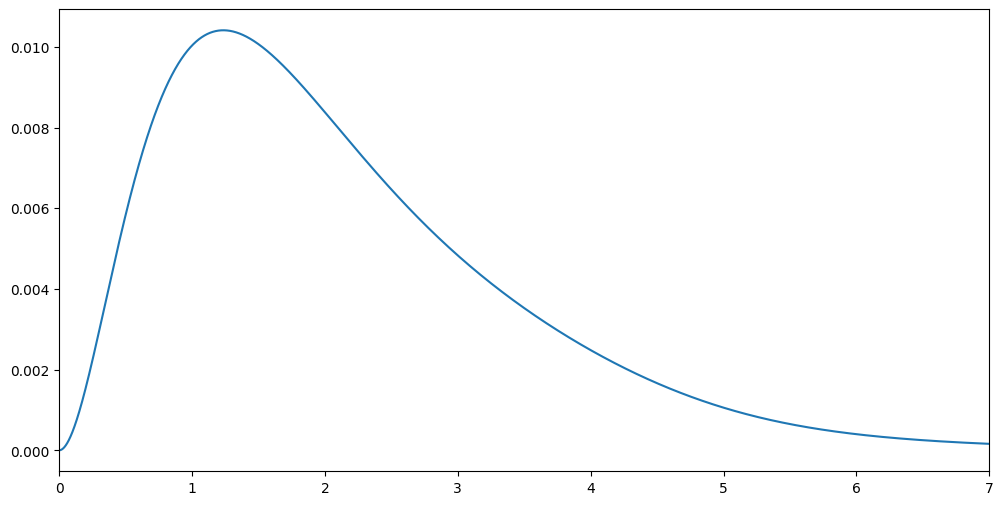

In [6]:
sparams = mass_function_prior.sample_prior_mean()

f, ax =plt.subplots(1, 1, figsize=(12, 6))

norm = mass_function_prior.n_tot(sparams)
dvdz = mass_function_prior.dvdz(mass_function_prior.z_grid, mass_function_prior.dz)

zs = mass_function_prior.z_grid
logms = mass_function_prior.logm_grid

#i=0
#n_z=[]
#for z in zs:
#    n_logm = mass_function_prior.normalised_mass_function(z, mass_function_prior.logm_grid, sparams, norm, dvdz[i])
#    n_logm = np.trapz(n_logm, mass_function_prior.logm_grid)
#    n_z.append(n_logm)
#    i+=1

#print(np.trapz(n_z, mass_function_prior.z_grid))

n=[]
i=0
for z in zs:
    n.append(mass_function_prior.normalised_mass_function(z, 10, sparams, norm, dvdz[i]))

    i+=1

ax.plot(zs, n)
ax.set_xlim(0, 7)
#ax.set_ylim(0, 0.018)

In [7]:
n_prior_samples = 100
nsamples=500000
zbins = np.linspace(0.0, 7.0, 100)
zarr=[]
nlssts=[]
#zs=[]
for i in range(n_prior_samples):
    zsamples, msamples, nlsst = mass_function_prior.sample_logpdf(nsamples)
    z_histogram = np.histogram(zsamples, bins=zbins, density=True)
    #zs.append(zsamples)
    zarr.append(z_histogram[0])
    nlssts.append(nlsst)



Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sa

5478543376.8069315 1351850203.5422997


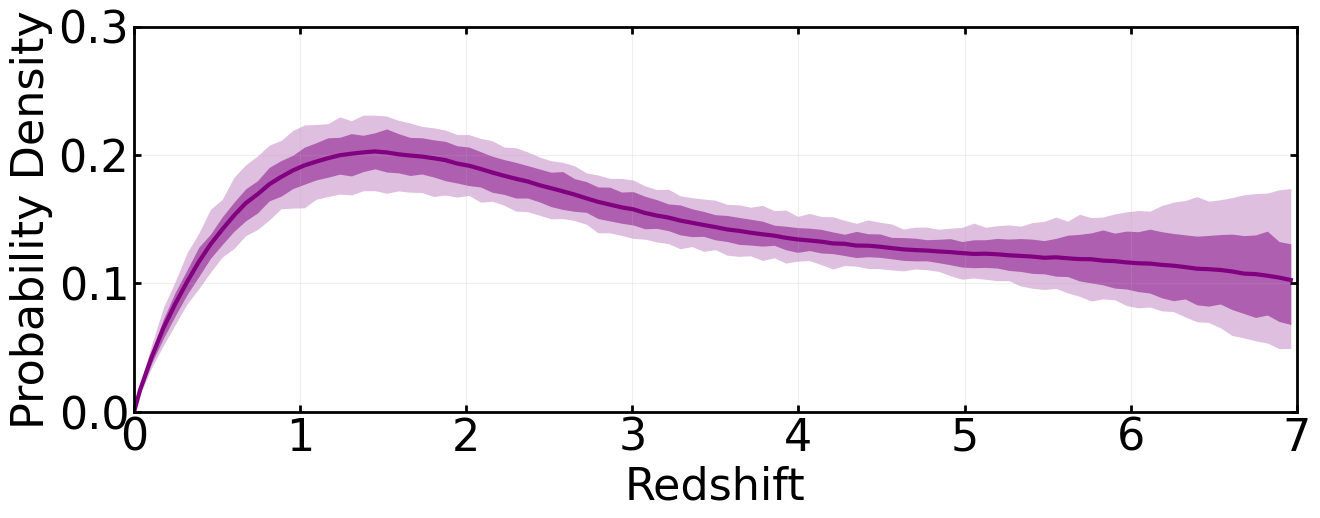

In [8]:
fig = plt.figure(figsize=(15, 5))
ax=fig.gca()

zs = np.vstack(np.array(zarr))
#np.save("zsamples_unnormalised.npy", zs)

#zs= np.load("zsamples_normalised.npy")

p1=84
percentile_zs1 = np.percentile(zs, [100-p1, 50, p1], axis=0)

p2=97.5
percentile_zs2 = np.percentile(zs, [100-p2, 50, p2], axis=0)

alpha=0.5
colour='purple'

zs_mean = np.concatenate((np.array([0]), np.mean(zs, axis=0)))
z_x = np.concatenate((np.array([0]), (zbins[:-1]+zbins[1:])/2))
upper1 = np.concatenate((np.array([0]), percentile_zs1[2, :]))
upper2 = np.concatenate((np.array([0]), percentile_zs2[2, :]))
lower1 = np.concatenate((np.array([0]), percentile_zs1[0, :]))
lower2 = np.concatenate((np.array([0]), percentile_zs2[0, :]))

fs=32
ax.plot(z_x, zs_mean, lw=3, color='purple', ls='-', label='Mean')
ax.fill_between(z_x, lower1,  upper1, alpha=alpha, color=colour, lw=0, label=str(100-p1)+"-"+str(p1)+"th Percentiles")
ax.fill_between(z_x, lower2,  upper2, alpha=alpha/2, color=colour, lw=0, label=str(100-p2)+"-"+str(p2)+"th Percentiles")
ax.set_xlabel('Redshift', fontsize=fs)
ax.set_ylabel('Probability Density', fontsize=fs)
ax.tick_params('x', labelsize=fs, width=2, size=5, direction='in', top=True)
ax.tick_params('y', labelsize=fs, width=2, size=5, direction='in', right=True)
ax.grid(visible=True, zorder=-1, alpha=0.2)
ax.set_xlim(0, 7)
ax.set_ylim(0, 0.3)
#ax.legend(fontsize=24)

lw=2
ax.spines['bottom'].set_linewidth(lw)
ax.spines['top'].set_linewidth(lw)
ax.spines['right'].set_linewidth(lw)
ax.spines['left'].set_linewidth(lw)

print(np.mean(nlssts), np.std(nlssts))


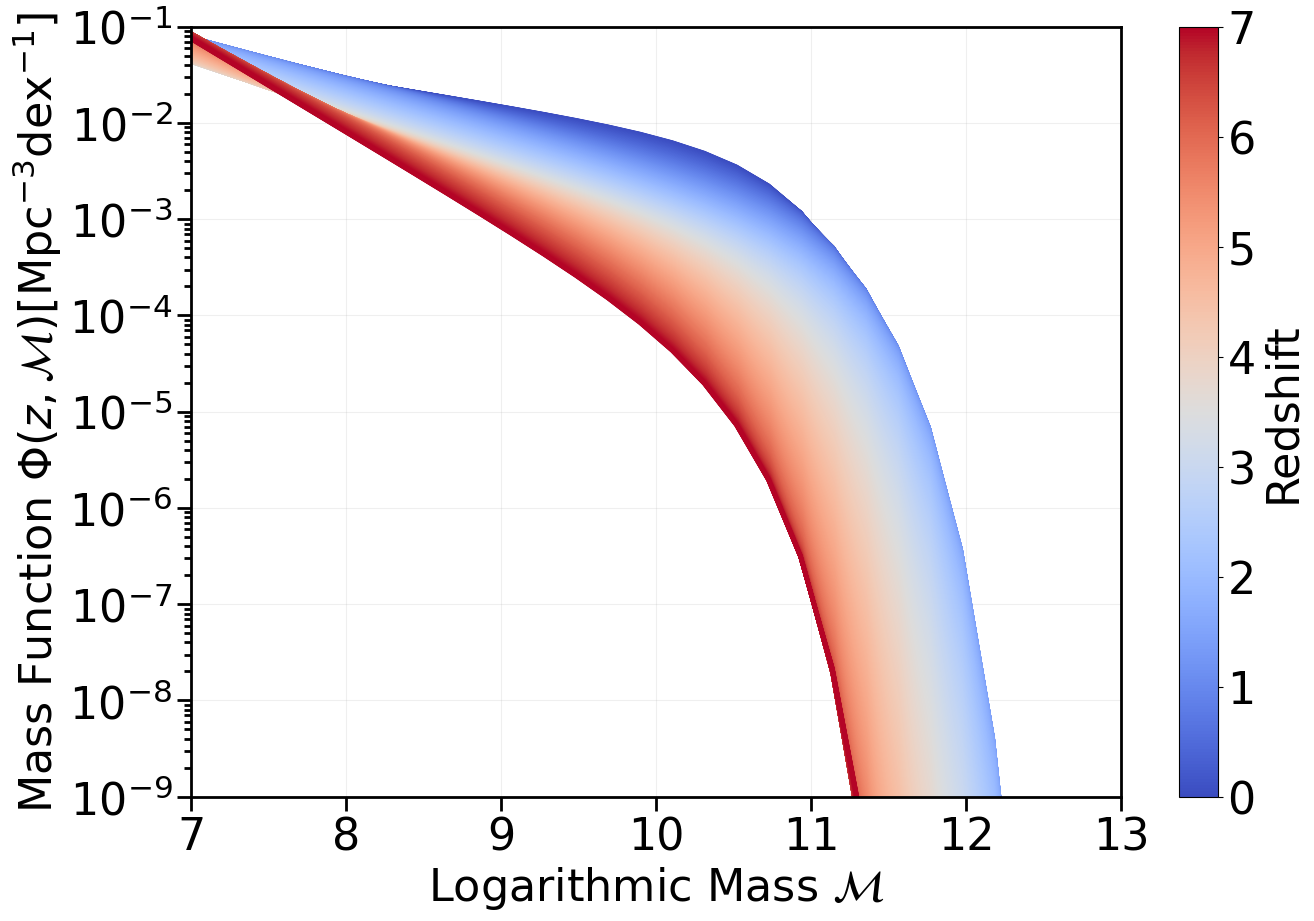

In [9]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=(15, 10))
ax=fig.gca()

cmap = plt.get_cmap('coolwarm')

redshift = np.linspace(0, 7, 1000)
masses = np.linspace(7, 13, 30)
nsamples = 1
for z in redshift:
    mfunc_at_z = []
    for n in range(nsamples):
        mfunc = mass_function_prior.mass_function(z, masses, mass_function_prior.sample_prior_mean())
        mfunc_at_z.append(mfunc)

    mfunc_at_z = np.vstack(np.array(mfunc_at_z))
    mfunc_at_z_mean = np.mean(mfunc_at_z, axis=0)
    mfunc_at_z_err = np.percentile(mfunc_at_z, [95, 50, 5], axis=0)

    #print(mfunc_at_z_mean, mfunc_at_z_err[0, :])

    ax.plot(masses, mfunc_at_z_mean, color=cmap(z/7), label="$z$="+str(z), lw=3)
    #ax.fill_between(masses, mfunc_at_z_err[0, :],  mfunc_at_z_err[2, :], color=cmap(z/6), alpha=0.3, lw=0)

fs=32            
ax.set_ylim(1e-9, 1e-1)
ax.set_xlim(7, 13)
ax.set_ylabel("Mass Function $\Phi(z, \mathcal{M}) [\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}]$", fontsize=fs)
ax.set_xlabel("Logarithmic Mass $\mathcal{M}$", fontsize=fs)
plt.tick_params('x', labelsize=fs, width=2, size=10)
plt.tick_params('y', labelsize=fs, width=2, size=10)

ax.tick_params(which='minor', width=2, size=5)

ax.set_yscale('log')
#ax.legend(loc="best", fontsize=24)
ax.grid(visible=True, zorder=-1, alpha=0.2)
cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=0, vmax=7), cmap=cmap), ax=ax)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label("Redshift", size=fs) 

lw=2
ax.spines['bottom'].set_linewidth(lw)
ax.spines['top'].set_linewidth(lw)
ax.spines['right'].set_linewidth(lw)
ax.spines['left'].set_linewidth(lw)

In [12]:
def plot_mass_function_in_zbin(ax, zl, zu):

    cmap = plt.get_cmap('coolwarm')
    lw=3

    dz=0.05
    redshift = np.linspace(zl, zu, int((zu-zl)/dz)+1)
    masses = np.linspace(8, 12, 40)
    nsamples = 5000

    mfunc_tot = []
    for z in redshift:
        for n in range(nsamples):
            mfunc = mass_function_prior.mass_function(z, masses, mass_function_prior.sample_prior())
            mfunc_tot.append(mfunc)

    mfunc_tot = np.log10(np.vstack(np.array(mfunc_tot)))
    mfunc_mean = np.mean(mfunc_tot, axis=0)
    p2=97.5
    p1=84
    mfunc_err = np.percentile(mfunc_tot, [p2, p1, 50, 100-p1, 100-p2], axis=0)

    ax.plot(masses, mfunc_mean, color=cmap(z/6), label=str(zl)+"$\leq z \less$"+str(zu), lw=lw, zorder=-zl)
    #ax.fill_between(masses, mfunc_err[0, :],  mfunc_err[-1, :], color=cmap(z/6), alpha=0.1, lw=0, zorder=-zl)
    ax.fill_between(masses, mfunc_err[1, :],  mfunc_err[3, :], color=cmap(z/6), alpha=0.4, lw=0, zorder=-zl)

    fs=32            
    ax.set_ylim(-6.5, -1.5)
    ax.set_xlim(8, 12)
    ax.set_ylabel("Mass Function $\Phi(z, \mathcal{M}) [\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}]$", fontsize=fs)
    ax.set_xlabel("Logarithmic Mass $\mathcal{M}$", fontsize=fs)
    plt.tick_params('x', labelsize=fs, width=2, size=10)
    plt.tick_params('y', labelsize=fs, width=2, size=10)

    ax.tick_params(which='minor', width=2, size=5)

    ax.legend(loc="lower left", fontsize=24)
    ax.grid(visible=True, zorder=-1, alpha=0.2)

    lw=2
    ax.spines['bottom'].set_linewidth(lw)
    ax.spines['top'].set_linewidth(lw)
    ax.spines['right'].set_linewidth(lw)
    ax.spines['left'].set_linewidth(lw)


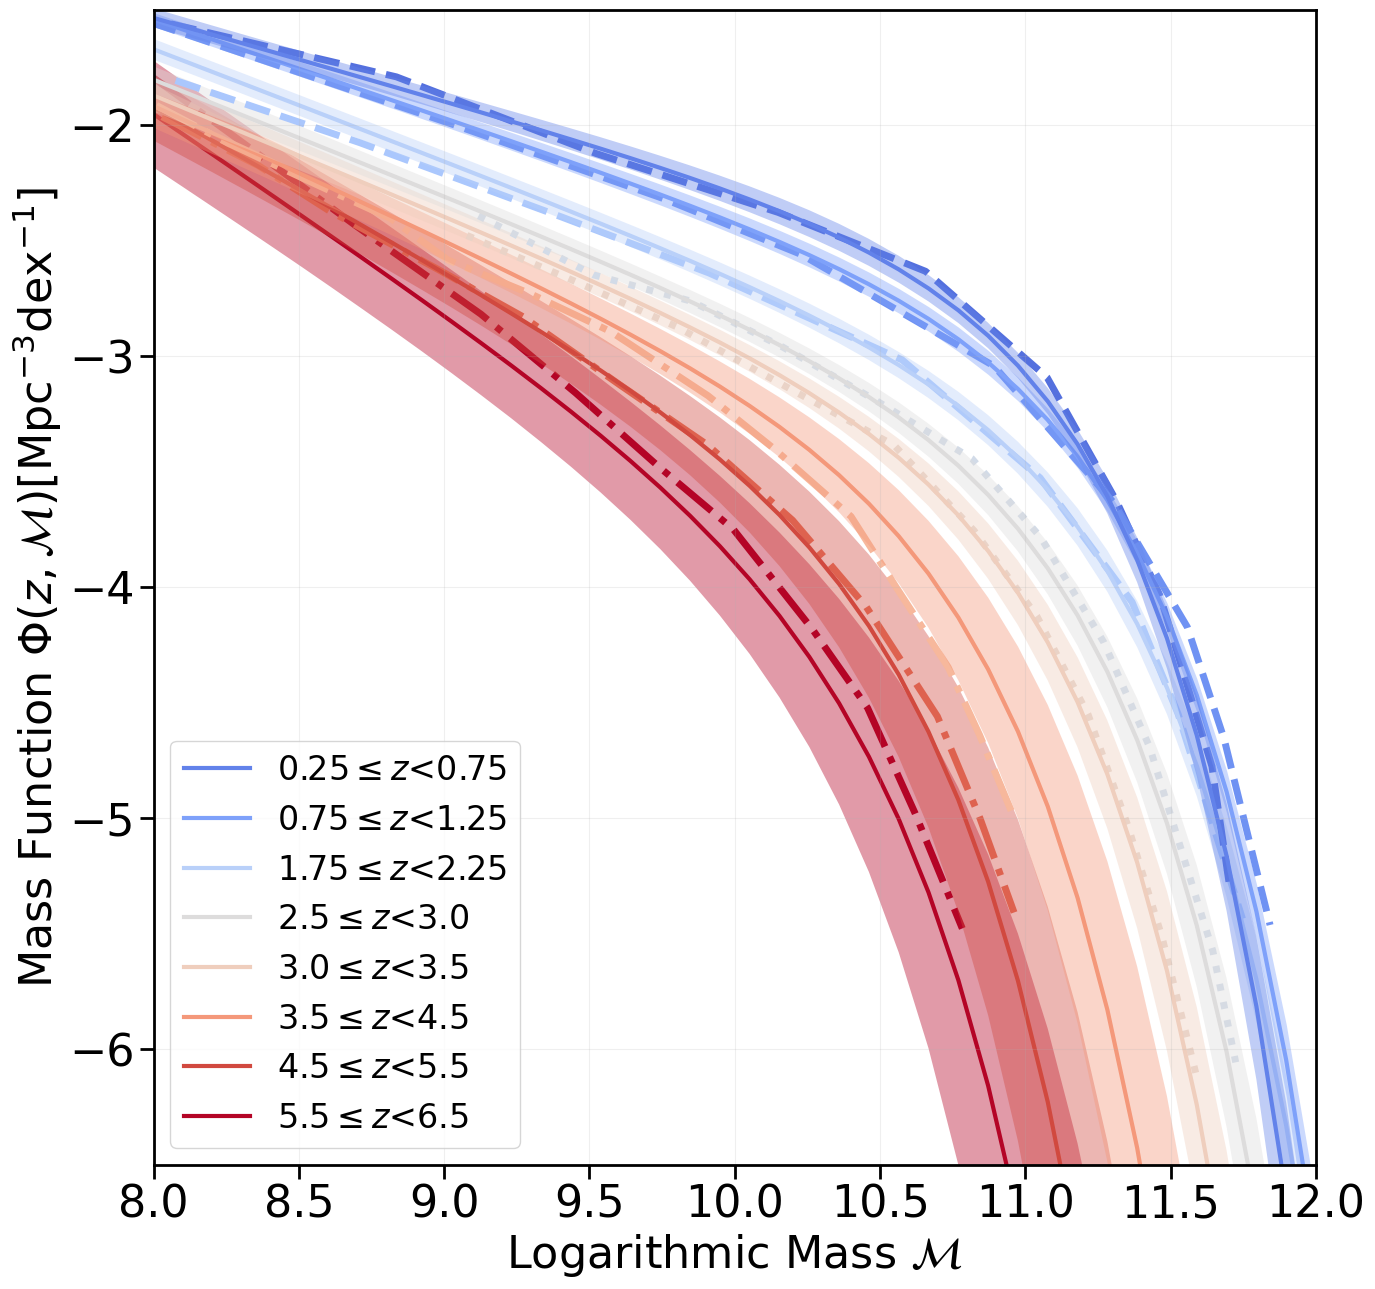

In [13]:
lw=5
cmap = plt.get_cmap('coolwarm')

#0.75-1.25
fig1 = plt.figure(figsize=(15, 15))
ax1=fig1.gca()


plot_mass_function_in_zbin(ax1, 0.25, 0.75)
x = [8.059701492537313, 8.835820895522389, 9.522388059701493, 10.149253731343283, 10.656716417910449, 11.074626865671641, 11.313432835820896, 11.462686567164178, 11.64179104477612, 11.701492537313433]
y = [-1.5612244897959187, -1.7908163265306118, -2.1224489795918364, -2.377551020408163, -2.63265306122449, -3.0918367346938775, -3.627551020408163, -4.035714285714286, -4.775510204081632, -5.285714285714286]
ax1.plot(x, y, '--', lw=lw, c=cmap(0.5/6), zorder=-1)


plot_mass_function_in_zbin(ax1, 0.75, 1.25)
x = np.array([7.3164556962025316, 7.759493670886076, 8.455696202531646, 9.025316455696203, 9.753164556962025, 10.227848101265824, 10.89240506329114, 11.30379746835443, 11.556962025316455, 11.683544303797468, 11.841772151898734])
y = np.array([-1.268817204301075, -1.456989247311828, -1.752688172043011, -1.994623655913978, -2.317204301075269, -2.5591397849462365, -3.043010752688172, -3.6344086021505375, -4.172043010752688, -4.655913978494624, -5.46236559139785])
ax1.plot(x, y, '--', lw=lw, c=cmap(1/6), zorder=-1)


plot_mass_function_in_zbin(ax1, 1.75, 2.25)
x = np.array([8.075949367088608, 8.708860759493671, 9.405063291139241, 9.911392405063292, 10.575949367088608, 11.050632911392405, 11.367088607594937, 11.525316455696203, 11.746835443037975])
y = np.array([-1.806451612903226, -2.075268817204301, -2.3978494623655915, -2.639784946236559, -3.0161290322580645, -3.5268817204301075, -4.064516129032258, -4.548387096774194, -5.435483870967742])
ax1.plot(x, y, '--', lw=lw, c=cmap(2/6), zorder=-2)

#plot_mass_function_in_zbin(ax1, 2.25, 2.75)
#x = [8.26865671641791, 9.074626865671641, 9.73134328358209, 10.328358208955224, 10.746268656716417, 11.134328358208954, 11.373134328358208, 11.552238805970148, 11.64179104477612, 11.761194029850746]
#y = [-1.7142857142857144, -2.2244897959183674, -2.607142857142857, -3.0408163265306123, -3.4744897959183674, -3.933673469387755, -4.494897959183674, -4.928571428571429, -5.413265306122449, -5.974489795918367]
#ax1.plot(x, y, '--', lw=lw, c=cmap(2.5/6), zorder=-2.25)

plot_mass_function_in_zbin(ax1, 2.5, 3.0)
x = np.array([9.118421052631579, 9.513157894736842, 9.848684210526315, 10.164473684210526, 10.480263157894736, 10.81578947368421, 11.052631578947368, 11.269736842105264, 11.427631578947368, 11.546052631578947, 11.644736842105264, 11.723684210526315])
y = np.log10(np.array([0.004054660959462169, 0.0022504674056497025, 0.0017323528848992831, 0.0010959045429956764, 0.0006493816315762113, 0.00036042771770583164, 0.0001644027549618668, 0.0000577249594304303, 0.000020268340041003042, 0.000006665974321719075, 0.000002667696159952092, 8.773680560131944e-7]))
ax1.plot(x, y, ':', lw=lw, c=cmap(2.75/6), zorder=-2.75)


plot_mass_function_in_zbin(ax1, 3.0, 3.5)
x = np.array([9.07843137254902, 9.450980392156863, 9.803921568627452, 10.215686274509803, 10.549019607843137, 10.823529411764707, 11.03921568627451, 11.215686274509803, 11.352941176470589, 11.470588235294118, 11.588235294117647])
y = np.log10(np.array([0.0033321709412448166, 0.0021079661680828274, 0.001333521432163324, 0.0006932806692144523, 0.0004108056080177276, 0.0001755165936923892, 0.00007498942093324559, 0.00002811018063413649, 0.000009245046309020041, 0.000003040566774307057, 7.697747057123718e-7]))
ax1.plot(x, y, ':', lw=lw, c=cmap(3.25/6), zorder=-3.25)

plot_mass_function_in_zbin(ax1, 3.5, 4.5)
x = np.array([8.00983606557377, 8.255737704918033, 8.560655737704918, 8.816393442622951, 9.01311475409836, 9.298360655737705, 9.573770491803279, 9.908196721311477, 10.134426229508197, 10.4, 10.557377049180328, 10.734426229508196, 10.842622950819672, 10.950819672131148])
y = np.log10(np.array([0.01218187912010116, 0.008364673227799466, 0.005531681197617227, 0.003943831644306426, 0.002608113761201518, 0.0018594639162879234, 0.0012767987504462759, 0.0006738627168030948, 0.00039810717055349735, 0.00020235896477251576, 0.00009906457195491435, 0.00004498432668969444, 0.000022865656419247956, 0.000010780851432948595]))
ax1.plot(x, y, '-.', lw=lw, c=cmap(4/6), zorder=-4)

plot_mass_function_in_zbin(ax1, 4.5, 5.5)
x = np.array([8.029315960912053, 8.36156351791531, 8.60586319218241, 8.967426710097719, 9.270358306188925, 9.602605863192181, 9.905537459283387, 10.19869706840391, 10.452768729641694, 10.697068403908794, 10.843648208469055, 10.960912052117264])
y = np.log10(np.array([0.010882650800586027, 0.006675592159647419, 0.004251786303382895, 0.00241920944502636, 0.001483981788967566, 0.0007543120063354622, 0.0004133581745292434, 0.00019489285531480827, 0.00008208914159638262, 0.000027594105890135863, 0.00001, 0.000003906939937054621]))
ax1.plot(x, y, '-.', lw=lw, c=cmap(5/6), zorder=-5)

plot_mass_function_in_zbin(ax1, 5.5, 6.5)
x = np.array([8, 8.298642533936652, 8.692307692307692, 9.126696832579185, 9.452488687782806, 9.737556561085974, 9.995475113122172, 10.266968325791854, 10.457013574660634, 10.619909502262443, 10.782805429864254])
y = np.log10(np.array([0.016015682644458355, 0.008547088125592519, 0.0036998304144069656, 0.0015199110829529332, 0.0006932806692144523, 0.00033321709412448166, 0.00017782794100389227, 0.00006579332246575683, 0.00003001046517818875, 0.000010537249727360724, 0.0000033321709412448166]))
ax1.plot(x, y, '-.', lw=lw, c=cmap(6/6), zorder=-6)